In [17]:
%%capture
!pip install google-play-scraper

In [18]:
# Import necessary librariesf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import app, Sort, reviews_all

In [9]:
from google_play_scraper import reviews_all, Sort
import pandas as pd
import numpy as np

countries = ['VN', 'BR', 'TH', 'ES', 'JP', 'FR', 'US', 'TW', 'PL', 'DE']
# Khởi tạo danh sách để lưu trữ tất cả các đánh giá
all_reviews = []

# Lặp qua từng mã quốc gia để lấy đánh giá và thêm trường country
for country_code in countries:
    reviews = reviews_all(
        'com.techpro.livevideo.wallpaper',
        sleep_milliseconds=0,
        lang='en',  # Ngôn ngữ mặc định
        country=country_code,  # Mã quốc gia hiện tại trong vòng lặp
        sort=Sort.NEWEST
    )
    # Thêm trường 'country' vào mỗi đánh giá
    for review in reviews:
        review['country'] = country_code
    all_reviews.extend(reviews)  # Thêm đánh giá từ quốc gia hiện tại vào danh sách tất cả đánh giá

df_reviews = pd.DataFrame(all_reviews)

df_reviews.to_csv('reviews.csv', index=False, encoding='utf-8')


In [7]:
# Create new dataframe with review content and score for further analysis
df_reviews_content = pd.DataFrame(df_reviews, columns=['content','score'])

NameError: name 'df_reviews' is not defined

In [3]:
%%capture
!pip install transformers

In [4]:
# from transformers import pipeline

# sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english", batch_size =8, truncation=True)

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline
import torch

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Áp dụng quantization
model_quantized = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

sentiment_analysis = pipeline("sentiment-analysis", model=model_quantized, tokenizer=tokenizer, batch_size=16, truncation=True)


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [5]:
df_reviews = pd.read_csv("/kaggle/input/hhhhhh/reviews.csv")
df_reviews['content'] = df_reviews['content'].astype('str')
df_reviews['content']

0                            That have the best home srens
1                                          Best wallpapers
2                        It keeps saying it can't download
3                                            It's the best
4        Seems like after every update they remove the ...
                               ...                        
67205                                  Good wallpapers 😁 😁
67206    It plays ads even when it isnt open please fix...
67207                     Like it as has many anime pics 😘
67208    I like all the things I have see still more to...
67209       Great app. It just works! Love the wallpapers.
Name: content, Length: 67210, dtype: object

In [6]:
# df_reviews['result'] = df_reviews['content'].apply(lambda x: sentiment_analysis(x))

from tqdm import tqdm
tqdm.pandas()  # Kích hoạt tqdm cho pandas

df_reviews['result'] = df_reviews['content'].progress_apply(lambda x: sentiment_analysis(x))

100%|██████████| 67210/67210 [1:35:14<00:00, 11.76it/s]  


In [7]:
df_reviews['sentiment'] = df_reviews['result'].apply(lambda x: x[0]['label'])
df_reviews['resultScore'] = df_reviews['result'].apply(lambda x: x[0]['score'])

In [8]:
df_reviews['sentiment'].value_counts(normalize=True)


sentiment
POSITIVE    0.860437
NEGATIVE    0.139563
Name: proportion, dtype: float64

In [9]:
df_reviews.to_csv("reviews_sentiments.csv")

In [10]:
!pip install plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
import plotly.express as px
import pandas as pd
data = pd.read_csv("/kaggle/input/oooooo/reviews_sentiments.csv")
# data = df_reviews

In [7]:
fig = px.histogram(data, x='sentiment', color='sentiment', text_auto=True)
fig.show()

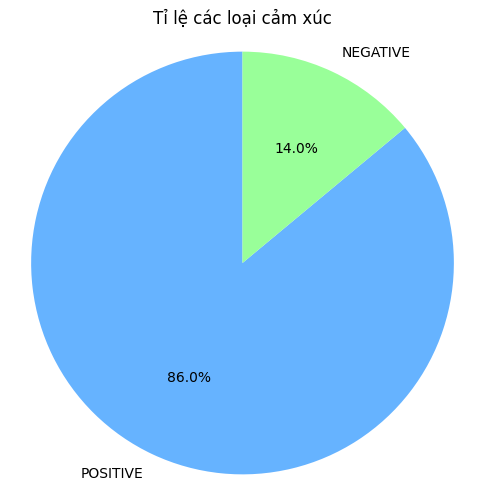

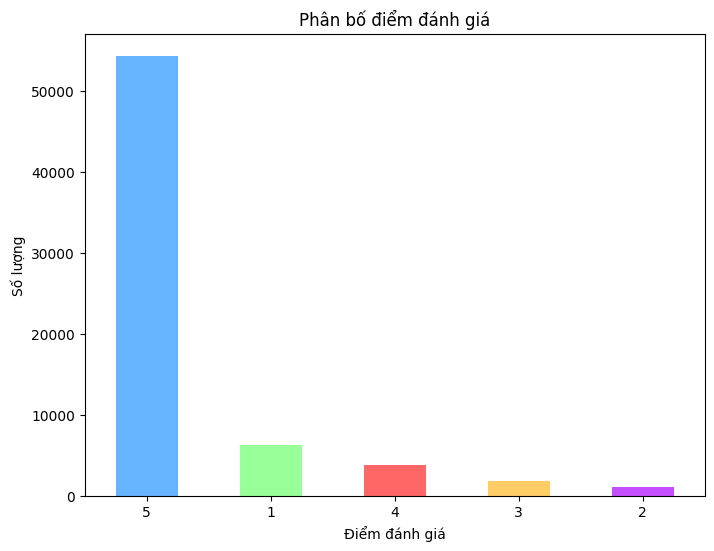

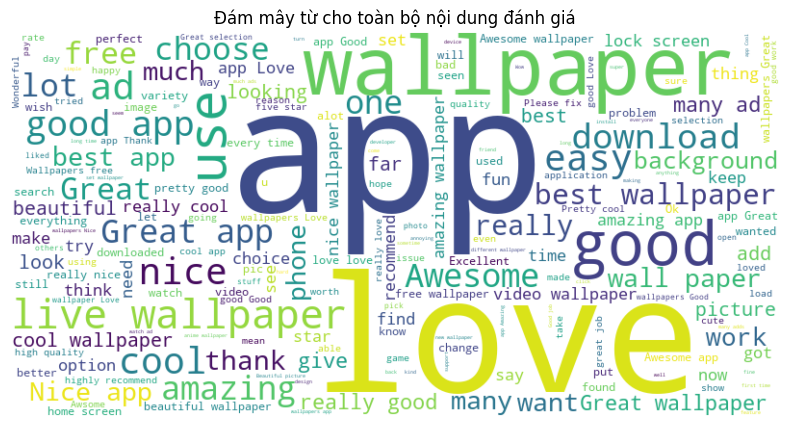

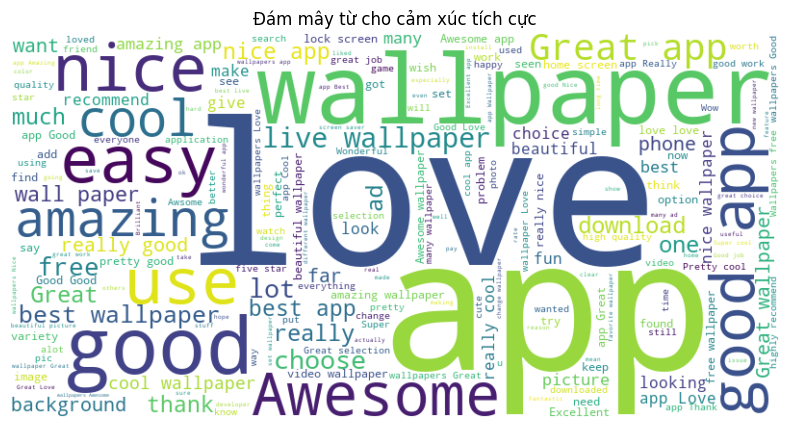

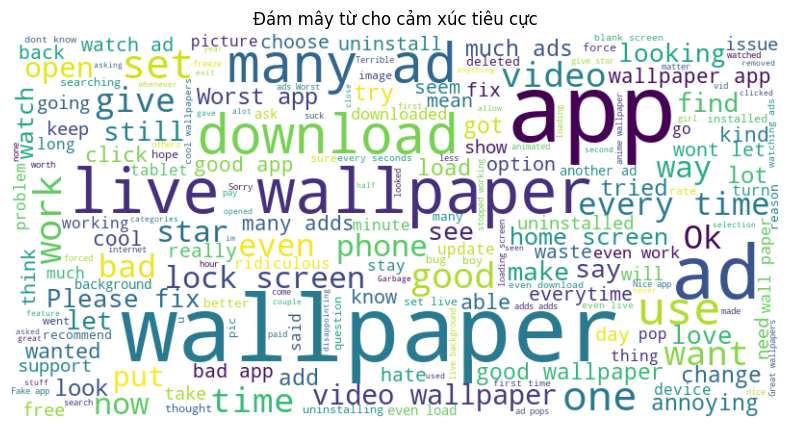

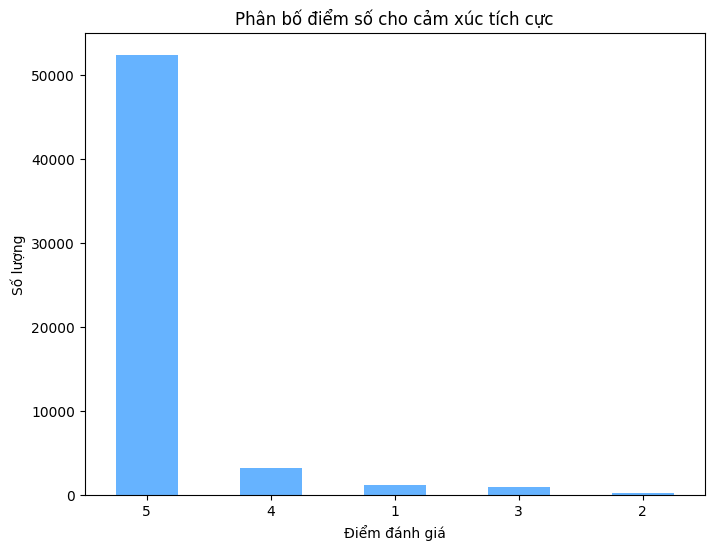

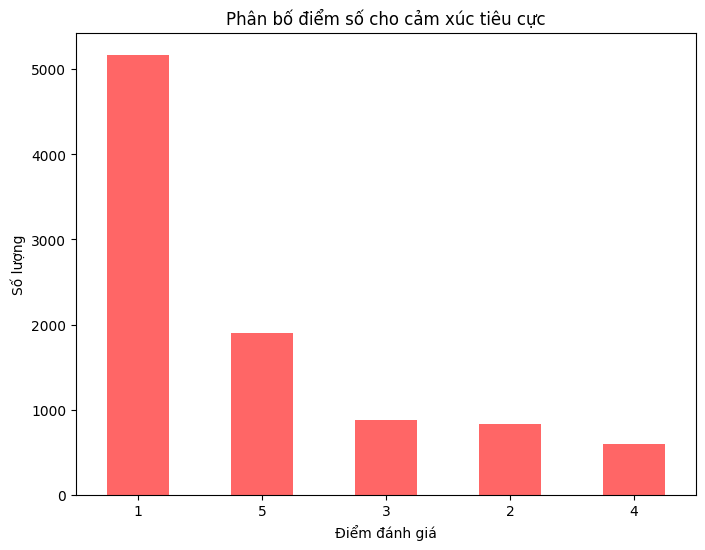

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Phân tích thống kê các cảm xúc và điểm đánh giá
sentiment_counts = data['sentiment'].value_counts()
score_distribution = data['score'].value_counts()

# Vẽ biểu đồ phân bố cảm xúc
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff6666'])
plt.title('Tỉ lệ các loại cảm xúc')
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()

# Vẽ biểu đồ phân bố điểm số đánh giá
plt.figure(figsize=(8,6))
score_distribution.plot(kind='bar', color=['#66b3ff', '#99ff99', '#ff6666', '#ffcc66', '#c44dff'])
plt.title('Phân bố điểm đánh giá')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.show()

# Tạo đám mây từ (word cloud) từ nội dung đánh giá
text_content = ' '.join(data['content'].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_content)

# Hiển thị đám mây từ
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Tắt trục tọa độ
plt.title('Đám mây từ cho toàn bộ nội dung đánh giá')
plt.show()

# Tạo đám mây từ cho cảm xúc tích cực
positive_reviews = data[data['sentiment'] == 'POSITIVE']
positive_text = ' '.join(positive_reviews['content'].dropna().astype(str).tolist())
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Đám mây từ cho cảm xúc tích cực')
plt.show()

# Tạo đám mây từ cho cảm xúc tiêu cực
negative_reviews = data[data['sentiment'] == 'NEGATIVE']
negative_text = ' '.join(negative_reviews['content'].dropna().astype(str).tolist())
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Đám mây từ cho cảm xúc tiêu cực')
plt.show()

# Vẽ biểu đồ phân bố điểm số đánh giá cho cảm xúc tích cực
positive_score_distribution = positive_reviews['score'].value_counts()

plt.figure(figsize=(8,6))
positive_score_distribution.plot(kind='bar', color='#66b3ff')
plt.title('Phân bố điểm số cho cảm xúc tích cực')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.show()

# Vẽ biểu đồ phân bố điểm số đánh giá cho cảm xúc tiêu cực
negative_score_distribution = negative_reviews['score'].value_counts()

plt.figure(figsize=(8,6))
negative_score_distribution.plot(kind='bar', color='#ff6666')
plt.title('Phân bố điểm số cho cảm xúc tiêu cực')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.show()


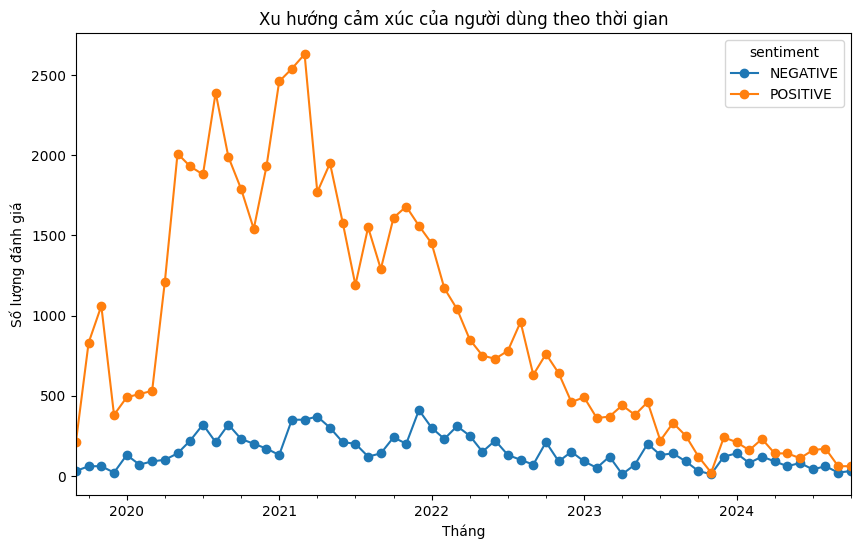

In [9]:
# Chuyển đổi cột 'at' thành dạng datetime
data['at'] = pd.to_datetime(data['at'])

# Nhóm dữ liệu theo tháng và cảm xúc, sau đó đếm số lượng đánh giá theo từng nhóm
monthly_sentiment = data.groupby([data['at'].dt.to_period('M'), 'sentiment']).size().unstack()

# Vẽ biểu đồ xu hướng cảm xúc theo thời gian
monthly_sentiment.plot(kind='line', figsize=(10,6), marker='o')
plt.title('Xu hướng cảm xúc của người dùng theo thời gian')
plt.xlabel('Tháng')
plt.ylabel('Số lượng đánh giá')
plt.show()


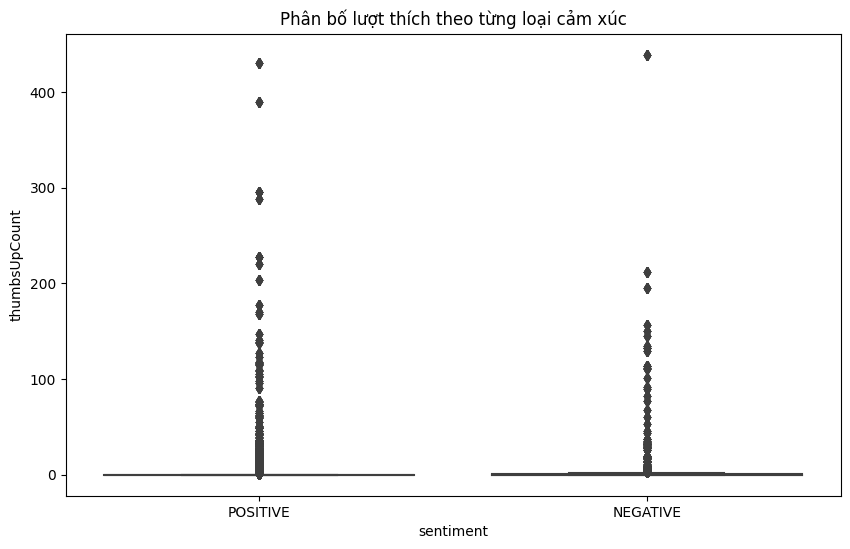


Thống kê lượt thích theo từng loại cảm xúc:
             count      mean        std  min  25%  50%  75%    max
sentiment                                                         
NEGATIVE    9380.0  4.502132  23.552373  0.0  0.0  0.0  1.0  439.0
POSITIVE   57830.0  1.768113  14.697536  0.0  0.0  0.0  0.0  430.0


In [13]:
# Thống kê lượt thích theo từng cảm xúc
thumbs_up_stats = data.groupby('sentiment')['thumbsUpCount'].describe()

# Vẽ biểu đồ phân bố lượt thích theo từng cảm xúc
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='thumbsUpCount', data=data)
plt.title('Phân bố lượt thích theo từng loại cảm xúc')
plt.show()

# Hiển thị thống kê mô tả
print("\nThống kê lượt thích theo từng loại cảm xúc:")
print(thumbs_up_stats)


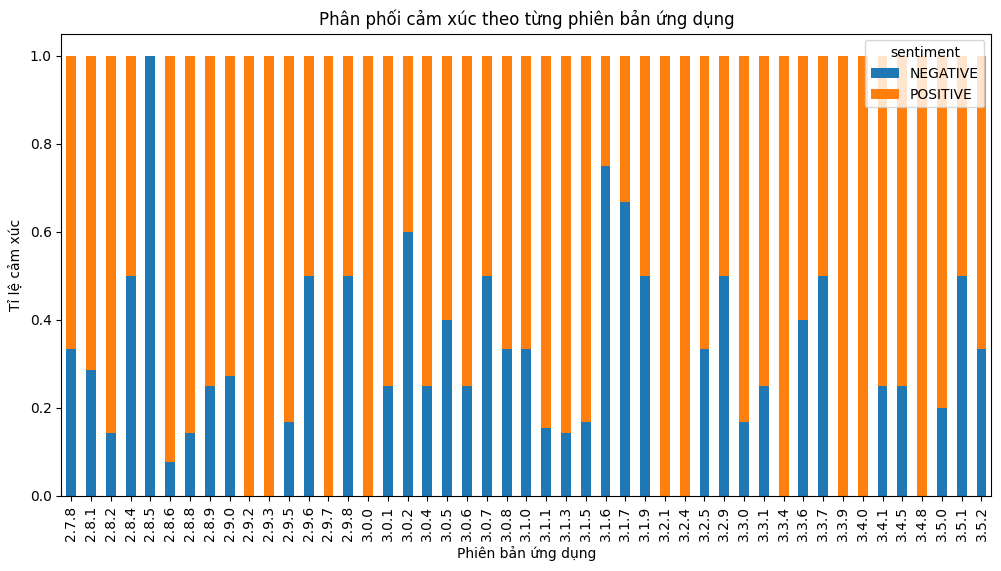

In [14]:
# Kiểm tra mối quan hệ giữa phiên bản ứng dụng và cảm xúc
version_sentiment_stats = data[data['appVersion'] > '2.7.7'].groupby('reviewCreatedVersion')['sentiment'].value_counts(normalize=True).unstack()

# Vẽ biểu đồ phân phối cảm xúc theo phiên bản ứng dụng
version_sentiment_stats.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Phân phối cảm xúc theo từng phiên bản ứng dụng')
plt.xlabel('Phiên bản ứng dụng')
plt.ylabel('Tỉ lệ cảm xúc')
plt.show()


In [18]:
data[data['appVersion'] == '3.5.2']

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,country,result,sentiment,resultScore
0,cdeee939-aa1f-45eb-ac5e-a13759413851,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,That have the best home srens,5,0,3.5.2,2024-10-26 04:10:44,NaN,NaN,3.5.2,VN,"[{'label': 'POSITIVE', 'score': 0.998654246330...",POSITIVE,0.998654
1,632e0fa1-0ef5-454e-8fc9-8f54293eeea1,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best wallpapers,4,0,3.5.2,2024-10-22 06:56:30,NaN,NaN,3.5.2,VN,"[{'label': 'POSITIVE', 'score': 0.997228205204...",POSITIVE,0.997228
2,dc7a9c05-f233-4ab8-a422-3663c70d3f37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps saying it can't download,1,0,3.5.2,2024-10-21 06:25:55,Hi Michelle kgosiyarona! Thanks for using our ...,2024-10-21 10:35:56,3.5.2,VN,"[{'label': 'NEGATIVE', 'score': 0.999489903450...",NEGATIVE,0.999490
6721,cdeee939-aa1f-45eb-ac5e-a13759413851,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,That have the best home srens,5,0,3.5.2,2024-10-26 04:10:44,NaN,NaN,3.5.2,BR,"[{'label': 'POSITIVE', 'score': 0.998654246330...",POSITIVE,0.998654
6722,632e0fa1-0ef5-454e-8fc9-8f54293eeea1,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best wallpapers,4,0,3.5.2,2024-10-22 06:56:30,NaN,NaN,3.5.2,BR,"[{'label': 'POSITIVE', 'score': 0.997228205204...",POSITIVE,0.997228
6723,dc7a9c05-f233-4ab8-a422-3663c70d3f37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps saying it can't download,1,0,3.5.2,2024-10-21 06:25:55,Hi Michelle kgosiyarona! Thanks for using our ...,2024-10-21 10:35:56,3.5.2,BR,"[{'label': 'NEGATIVE', 'score': 0.999489903450...",NEGATIVE,0.999490
13442,cdeee939-aa1f-45eb-ac5e-a13759413851,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,That have the best home srens,5,0,3.5.2,2024-10-26 04:10:44,NaN,NaN,3.5.2,TH,"[{'label': 'POSITIVE', 'score': 0.998654246330...",POSITIVE,0.998654
13443,632e0fa1-0ef5-454e-8fc9-8f54293eeea1,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Best wallpapers,4,0,3.5.2,2024-10-22 06:56:30,NaN,NaN,3.5.2,TH,"[{'label': 'POSITIVE', 'score': 0.997228205204...",POSITIVE,0.997228
13444,dc7a9c05-f233-4ab8-a422-3663c70d3f37,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps saying it can't download,1,0,3.5.2,2024-10-21 06:25:55,Hi Michelle kgosiyarona! Thanks for using our ...,2024-10-21 10:35:56,3.5.2,TH,"[{'label': 'NEGATIVE', 'score': 0.999489903450...",NEGATIVE,0.999490
20163,cdeee939-aa1f-45eb-ac5e-a13759413851,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,That have the best home srens,5,0,3.5.2,2024-10-26 04:10:44,NaN,NaN,3.5.2,ES,"[{'label': 'POSITIVE', 'score': 0.998654246330...",POSITIVE,0.998654


In [24]:
data_filtered = data[(data['appVersion'] == '2.7.7') & (data['sentiment'] == 'POSITIVE')][['content', 'score', 'appVersion', 'sentiment', 'country']]
data_filtered


,content,score,appVersion,sentiment,country


In [25]:
data_hate = data[(data['score'] == 5) & (data['sentiment'] == 'NEGATIVE')][['content', 'score', 'country']]
data_hate

,content,score
50,This is OK,5
75,Alright now,5
179,Different Wallpaper.,5
188,I can't download Wallpapers.....evn after watc...,5
193,It is very opp,5
...,...,...
67008,Ok,5
67125,Some good stuff if that's your thing! Even if ...,5
67149,Alot of beautiful wallpapers but not enough of...,5
67175,This is my first time wallpaper.,5


In [14]:
pd.set_option('display.max_colwidth', None)
data_hate = data[(data['score'] == 5) & (data['sentiment'] == 'NEGATIVE')][['content', 'score']]
data_hate.head(15)

,content,score
46,This is OK,5
71,Alright now,5
175,Different Wallpaper.,5
184,I can't download Wallpapers.....evn after watching adds....redowloaded the app...still not working.....it was best app ...but now It is not working.......Hope team will improve this app to make it best,5
189,It is very opp,5
257,I f that up,5
389,No need,5
394,It was great I accidently deleted it and I'm trying to get it backl No out look great,5
403,Wallpaper,5
404,Get what ya see,5


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
import string

# Đọc dữ liệu từ file CSV
df = data

# Chuyển đổi cột ngày tháng về định dạng datetime
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df['repliedAt'] = pd.to_datetime(df['repliedAt'], errors='coerce')

# Chuyển đổi cột 'score' thành số nguyên
df['score'] = df['score'].astype(int)

# Trích xuất nhãn sentiment và điểm số
df['sentiment'] = df['sentiment']
df['score'] = df['resultScore'].astype(float)

# Xử lý giá trị thiếu trong 'appVersion'
df['appVersion'] = df['appVersion'].fillna('Unknown')

# Thêm cột 'month_year' để phân tích theo thời gian
df['month_year'] = df['at'].dt.to_period('M')

# Đảm bảo cột 'content' là kiểu chuỗi
df['content'] = df['content'].astype(str)


## PHân tích theo thời gian và version


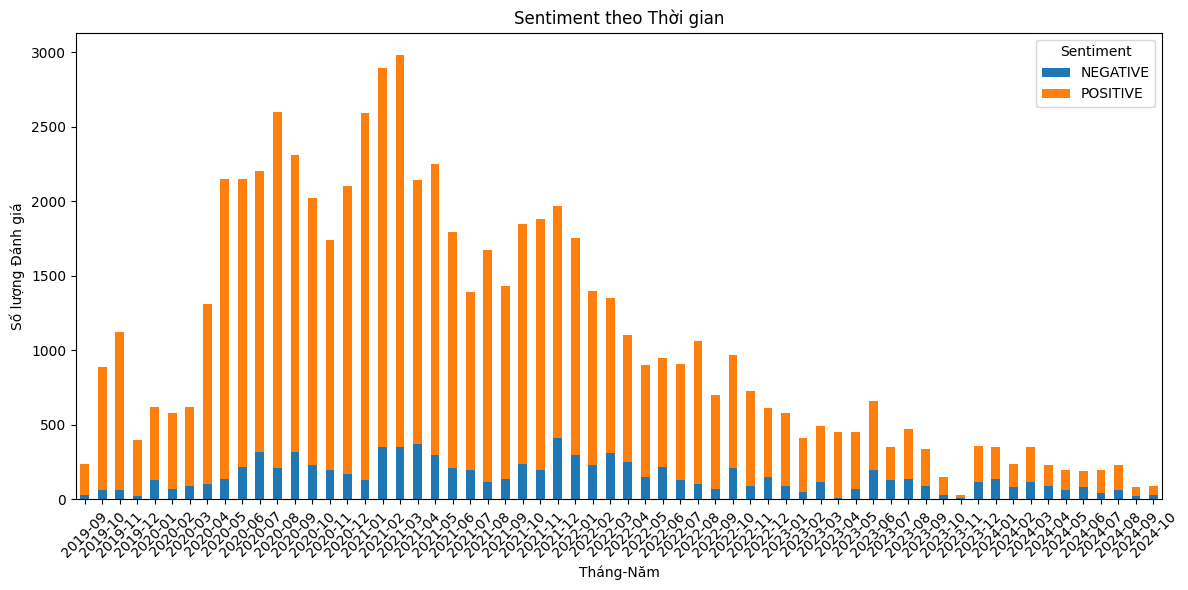

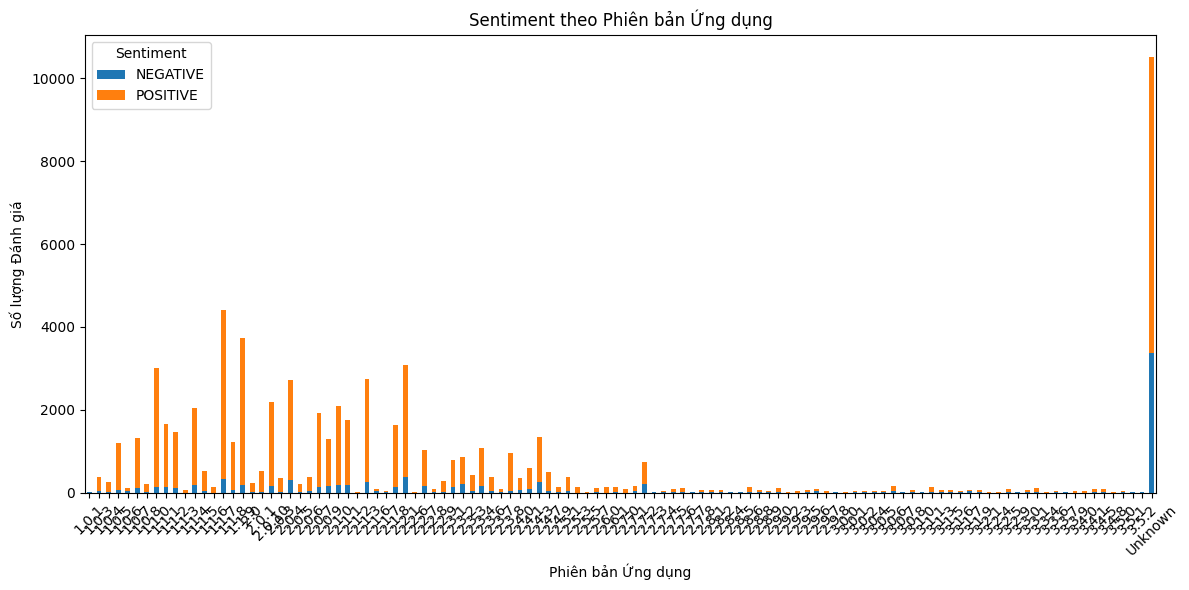

In [28]:
# Sentiment theo thời gian
sentiment_over_time = df.groupby(['month_year', 'sentiment_label']).size().unstack().fillna(0)
sentiment_over_time.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Sentiment theo Thời gian')
plt.xlabel('Tháng-Năm')
plt.ylabel('Số lượng Đánh giá')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Sentiment theo phiên bản ứng dụng
sentiment_by_version = df.groupby(['appVersion', 'sentiment_label']).size().unstack().fillna(0)
sentiment_by_version = sentiment_by_version.sort_index()
sentiment_by_version.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Sentiment theo Phiên bản Ứng dụng')
plt.xlabel('Phiên bản Ứng dụng')
plt.ylabel('Số lượng Đánh giá')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


Mối quan hệ giữa Điểm số và Sentiment

In [30]:
# Bảng chéo giữa 'score' và 'sentiment_label'
score_sentiment_crosstab = pd.crosstab(df['score'], df['sentiment_label'])
print(score_sentiment_crosstab)

# Tìm sự không nhất quán
# Đánh giá có điểm thấp nhưng sentiment tích cực
low_score_positive = df[(df['score'] <= 3) & (df['sentiment_label'] == 'POSITIVE')]
print("Đánh giá điểm thấp nhưng sentiment tích cực:")
print(low_score_positive[['content', 'score', 'sentiment_label']])

# Đánh giá có điểm cao nhưng sentiment tiêu cực
high_score_negative = df[(df['score'] >= 4) & (df['sentiment_label'] == 'NEGATIVE')]
print("Đánh giá điểm cao nhưng sentiment tiêu cực:")
print(high_score_negative[['content', 'score', 'sentiment_label']])


sentiment_label  NEGATIVE  POSITIVE
score                              
1                    5170      1150
2                     830       210
3                     880       910
4                     600      3170
5                    1900     52390
Đánh giá điểm thấp nhưng sentiment tích cực:
                                                 content  score  \
9                           Ir worc but i adds to mu ch😞      3   
24     Ok. It's not really bad, works fine, and I got...      3   
25                                            Very great      3   
95                                                  🤦‍♀️      2   
115    It's okay I had gruble 4D or something like th...      3   
...                                                  ...    ...   
67023                                            Crappie      1   
67030  I will look at all of them so it takes me a wh...      3   
67064                                              Dusta      1   
67102                            

## Mối quan hệ giữa Điểm số và Sentiment

In [ ]:
# Cài đặt và import spell checker
!pip install pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spelling(text):
    if isinstance(text, str):  # Kiểm tra nếu text là chuỗi
        words = text.split()
        corrected_words = [spell.correction(word) if spell.correction(word) else word for word in words]
        return ' '.join(corrected_words)
    return text  # Trả về text gốc nếu không phải chuỗi

# Áp dụng sửa lỗi chính tả cho nội dung
df['corrected_content'] = df['content'].apply(correct_spelling)

# Tái phân tích sentiment sử dụng nội dung đã sửa
from transformers import pipeline

# Tải mô hình phân tích sentiment
sentiment_analyzer = pipeline('sentiment-analysis')

# Áp dụng phân tích sentiment
df['corrected_sentiment'] = df['corrected_content'].apply(lambda x: sentiment_analyzer(x)[0]['label'] if isinstance(x, str) else 'UNKNOWN')
df['corrected_sentiment_score'] = df['corrected_content'].apply(lambda x: sentiment_analyzer(x)[0]['score'] if isinstance(x, str) else None)

# So sánh sentiment trước và sau khi sửa
comparison = df[['content', 'sentiment', 'corrected_content', 'corrected_sentiment']]
print(comparison)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
# Tìm kiếm đánh giá đề cập đến 'privacy', 'security', 'data'
df = data
df['mentions_privacy'] = df['content'].str.contains('privacy|security|data|permission', case=False, regex=True)

# Đếm số lượng đánh giá đề cập đến quyền riêng tư
privacy_counts = df['mentions_privacy'].value_counts()
privacy_counts.index = ['Không đề cập Quyền riêng tư', 'Đề cập Quyền riêng tư']
print(privacy_counts)

# Phân tích sentiment của những đánh giá này
privacy_sentiment = df[df['mentions_privacy']]['sentiment_label'].value_counts(normalize=True)
print("Sentiment của Đánh giá Đề cập Quyền riêng tư:")
print(privacy_sentiment)

# Vẽ biểu đồ
privacy_sentiment.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title('Sentiment của Đánh giá Đề cập Quyền riêng tư')
plt.ylabel('')
plt.show()


Không đề cập Quyền riêng tư    67100
Đề cập Quyền riêng tư             90
Name: count, dtype: int64


ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [30]:
# Lọc đánh giá tiêu cực
negative_reviews = df[df['sentiment'] == 'NEGATIVE']['content']

# Tiền xử lý văn bản
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    words = word_tokenize(text)
    # Loại bỏ stopwords và lemmatize
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return words

processed_reviews = negative_reviews.apply(preprocess_text)

# Chuẩn bị dữ liệu cho LDA
from gensim import corpora
import gensim

dictionary = corpora.Dictionary(processed_reviews)
corpus = [dictionary.doc2bow(text) for text in processed_reviews]

# Xây dựng mô hình LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=2,  # Điều chỉnh số lượng chủ đề
                                            random_state=42,
                                            passes=10)

# In ra các chủ đề
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


LookupError: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

sentiment_label
POSITIVE    57830
NEGATIVE     9380
Name: count, dtype: int64


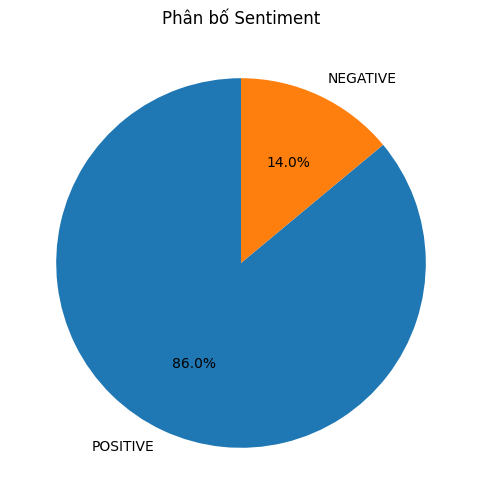

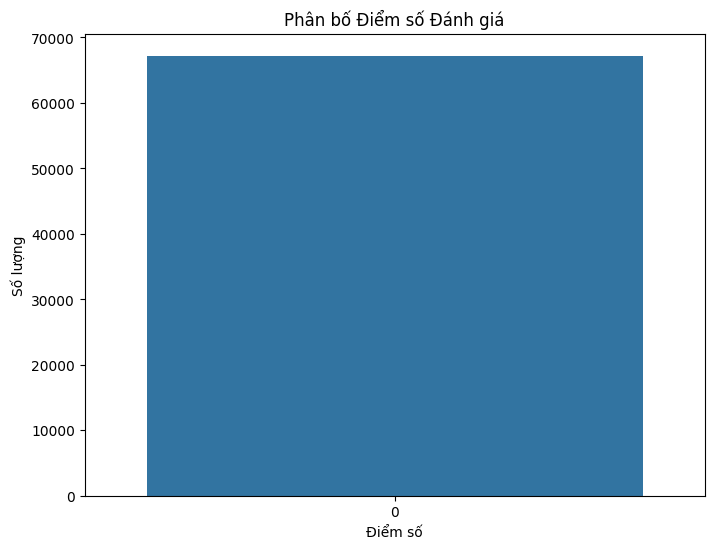

sentiment_label  NEGATIVE  POSITIVE
score                              
0                    9380     57830


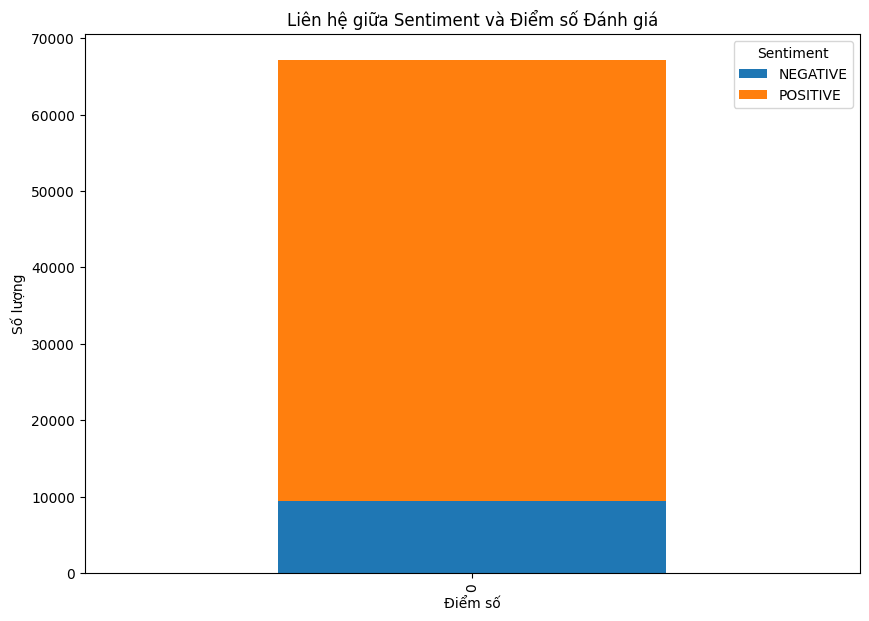

month_year
2019-09     240
2019-10     890
2019-11    1120
2019-12     400
2020-01     620
           ... 
2024-06     190
2024-07     200
2024-08     230
2024-09      80
2024-10      90
Freq: M, Length: 62, dtype: int64


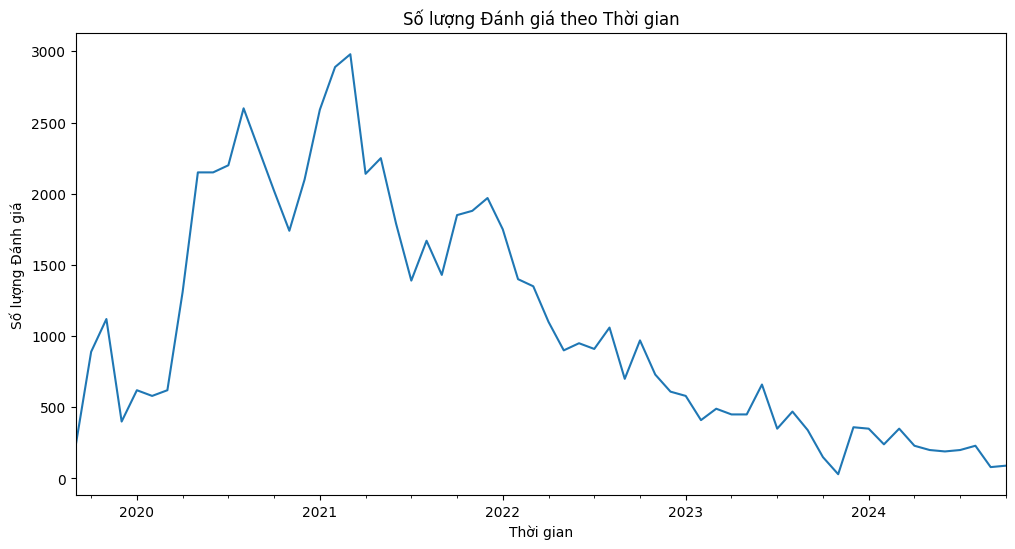

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Top 10 từ xuất hiện trong đánh giá tiêu cực: [('app', 3030), ('wallpaper', 2120), ('ads', 2030), ('wallpapers', 1990), ('live', 1110), ('dont', 960), ('many', 910), ('even', 850), ('like', 820), ('download', 800)]


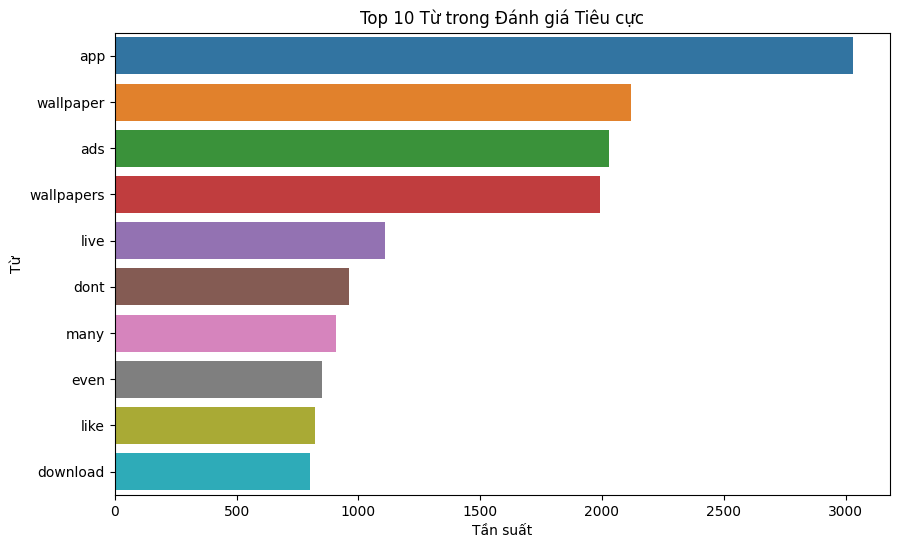

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ file CSV hoặc DataFrame
# Giả sử bạn đã lưu dữ liệu vào file 'reviews.csv'
# 
df = data
# Chuyển đổi cột 'at' và 'repliedAt' sang dạng datetime
df['at'] = pd.to_datetime(df['at'])
df['repliedAt'] = pd.to_datetime(df['repliedAt'])

# Chuyển đổi cột 'score' thành số nguyên
df['score'] = df['score'].astype(int)

# Trích xuất thông tin từ cột 'sentiment' và 'resultScore'
df['sentiment_label'] = df['sentiment'].apply(lambda x: x)
df['sentiment_score'] = df['resultScore'].astype(float)

# **1. Phân tích phân bố sentiment**
# Đếm số lượng đánh giá tích cực và tiêu cực
sentiment_counts = df['sentiment_label'].value_counts()
print(sentiment_counts)

# Vẽ biểu đồ tròn cho phân bố sentiment
plt.figure(figsize=(6, 6))
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Phân bố Sentiment')
plt.ylabel('')
plt.show()

# **2. Phân tích điểm số đánh giá (rating)**
# Vẽ biểu đồ histogram cho cột 'score'
plt.figure(figsize=(8, 6))
sns.countplot(x='score', data=df, order=sorted(df['score'].unique()))
plt.title('Phân bố Điểm số Đánh giá')
plt.xlabel('Điểm số')
plt.ylabel('Số lượng')
plt.show()

# **3. Liên hệ giữa sentiment và điểm số đánh giá**
# Tạo bảng chéo giữa 'sentiment_label' và 'score'
sentiment_score_cross = pd.crosstab(df['score'], df['sentiment_label'])
print(sentiment_score_cross)

# Vẽ biểu đồ cho bảng chéo
sentiment_score_cross.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Liên hệ giữa Sentiment và Điểm số Đánh giá')
plt.xlabel('Điểm số')
plt.ylabel('Số lượng')
plt.legend(title='Sentiment')
plt.show()

# **4. Phân tích theo thời gian**
# Thêm cột 'month_year' để phân tích theo tháng và năm
df['month_year'] = df['at'].dt.to_period('M')

# Đếm số lượng đánh giá theo thời gian
time_series = df.groupby('month_year').size()
print(time_series)

# Vẽ biểu đồ đường cho số lượng đánh giá theo thời gian
plt.figure(figsize=(12, 6))
time_series.plot()
plt.title('Số lượng Đánh giá theo Thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Số lượng Đánh giá')
plt.show()

# **5. Phân tích các vấn đề kỹ thuật được đề cập**
# Lọc các đánh giá tiêu cực
negative_reviews = df[df['sentiment_label'] == 'NEGATIVE']

# Tìm các từ khóa phổ biến trong nội dung đánh giá tiêu cực
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Tải stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Kết hợp tất cả nội dung đánh giá tiêu cực
negative_text = ' '.join(negative_reviews['content'].astype(str))

# Loại bỏ dấu câu và chuyển thành chữ thường
negative_text = negative_text.translate(str.maketrans('', '', string.punctuation)).lower()

# Tách từ
words = negative_text.split()

# Loại bỏ stopwords
filtered_words = [word for word in words if word not in stop_words]

# Đếm tần suất từ
word_counts = Counter(filtered_words)

# Lấy 10 từ phổ biến nhất
common_words = word_counts.most_common(10)
print("Top 10 từ xuất hiện trong đánh giá tiêu cực:", common_words)

# Vẽ biểu đồ cột cho các từ phổ biến
words_df = pd.DataFrame(common_words, columns=['Từ', 'Tần suất'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Tần suất', y='Từ', data=words_df)
plt.title('Top 10 Từ trong Đánh giá Tiêu cực')
plt.xlabel('Tần suất')
plt.ylabel('Từ')
plt.show()
